<a href="https://colab.research.google.com/github/Aayushktyagi/DeepLearning_Resources/blob/master/blindness_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_csv = 'drive/My Drive/Dataset/train.csv'
image_dataset = 'drive/My Drive/Dataset/blindness_train_images'
sample_csv = 'drive/My Drive/Dataset/sample_submission.csv'
test_dataset = 'drive/My Drive/Dataset/blindness_test_images'

  

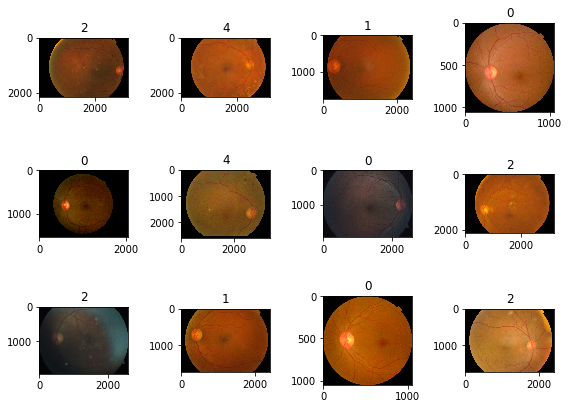

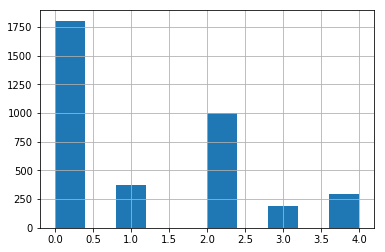

In [0]:
'''
preprocessing

1) load  csv data file
2) create train and test dataset
3) data statistics
'''

import tensorflow as tf
import os
import cv2
import numpy
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#parameters
num_classes = 5
def get_data():
    #load train and test data
    df_train = pd.read_csv(train_csv)
    x = df_train["id_code"].apply(lambda x:x+".png")
    y = df_train['diagnosis']
    x,y = shuffle(x,y,random_state = 8)
    y = to_categorical(y,num_classes = num_classes)
    train_x , valid_x , train_y , valid_y = train_test_split(x,y,test_size = 0.15)
    print("train:{},Test:{}".format(np.shape(train_x),np.shape(valid_y)))
    return train_x, valid_x , train_y , valid_y

def display_images_sample(df,columns=4,rows=3):
    fig = plt.figure(figsize=(2*columns,2*rows))

    for i in range(columns*rows):
        image_name = df.loc[i,'id_code']
        image_id  = df.loc[i,'diagnosis']
        image_path = os.path.join(image_dataset,image_name)
        image_path = image_path + '.png'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows,columns,i+1)
        plt.title(image_id)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

def data_dist(df_train):
    x = df_train['id_code']
    y = df_train['diagnosis']
    x,y = shuffle(x,y,random_state = 8)
    y.hist()
    plt.show()

df_train = pd.read_csv(train_csv)
display_images_sample(df_train)
data_dist(df_train)


In [0]:
'''
model
ResNet
'''

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.layers import Dense , Input , Flatten , Dropout ,BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications import Xception



img = Input(shape=(224,224,3))
# base_model = ResNet50(include_top = False,
#                 weights= 'imagenet',
#                 input_tensor = img,
#                 input_shape = None,
#                 pooling='avg')
# base_model = NASNetLarge(include_top = False,
#                         weights='imagenet',
#                         input_tensor=img,
#                         pooling='avg',
#                         input_shape = None)
base_model = Xception(include_top = False,
                        weights='imagenet',
                        input_tensor=img,
                        pooling='avg',
                        input_shape = None)

final_layer = base_model.layers[-1].output
final_layer = Dropout(0.2)(final_layer)
dense_layer1 = Dense(512, activation='relu')(final_layer)
dense_layer1 = Dropout(0.2)(dense_layer1)
dense_layer1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128,activation= 'relu')(dense_layer1)
# dense_layer2 = Dropout(0.3)(dense_layer2)
output_layer = Dense(5,activation='sigmoid')(dense_layer2)

model = Model(img,output_layer)
for layer in base_model.layers:
  layer.trainable = True

model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
model.summary() 


W0821 11:26:09.723964 139853149034368 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


83689472/83683744 [==============================] - 7s 0us/step


W0821 11:26:27.870655 139853149034368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
from keras.callbacks import LearningRateScheduler
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=30):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)
lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=30)

Using TensorFlow backend.


In [0]:
'''
main file

1) get dataset
2) load model
3) evaluate accuracy
'''
import numpy as np
import tensorflow as tf
import csv
import sys
import os
import cv2
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
#load train and test data
df_train = pd.read_csv(train_csv)
df_train["id_code"] = df_train["id_code"].apply(lambda x:x+".png")
df_train["diagnosis"] = df_train['diagnosis'].astype('str')


train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  validation_split = 0.15,
                                  zoom_range = 0.3,
                                  rotation_range = 30)
      
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = image_dataset,
    validation_split = 0.2,
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32,
    shaffle=True,
    subset = 'training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'id_code',
    y_col = 'diagnosis',
    directory = image_dataset,
    class_mode = "categorical",
    batch_size = 32,
    shaffle=True,
    target_size = (224,224),
    subset = "validation"
    )
optimizer = Adam(lr=0.0001, decay=1e-6)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = ModelCheckpoint(filepath='Blindness-detection.h5', monitor='val_loss', save_best_only=True)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history = model.fit_generator(
    train_generator,
    epochs = 50,
    steps_per_epoch = 30,
    validation_data = val_generator,
    validation_steps = 7,
    callbacks = [callbacks,early_stop,lr_sched]
)

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


W0821 14:12:15.044692 139853149034368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0821 14:12:15.046644 139853149034368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0821 14:12:15.059335 139853149034368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0821 14:12:15.367433 139853149034368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0821 14:12:15.374980 139853149034368 

Epoch 1/50


AttributeError: ignored

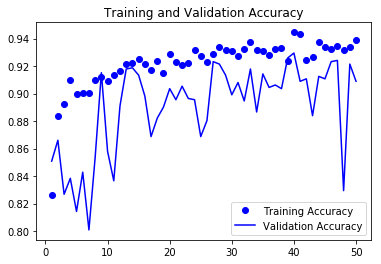

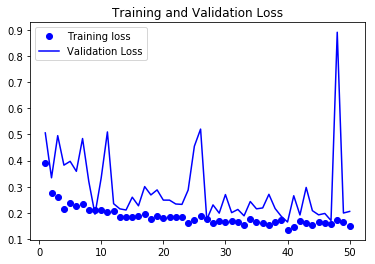

In [0]:
#plotting accuracies and losses
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [0]:
#make predictions on test images

test_datagen = ImageDataGenerator(rescale=1./255)


sample_df = pd.read_csv(sample_csv)

sample_df["id_code"]=sample_df["id_code"].apply(lambda x:x+".png")

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=sample_df,
        directory = test_dataset,    
        x_col="id_code",
        target_size = (224,224),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)
print(preds)


In [0]:
#sklearn confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_true = val_generator.classes
y_pred = np.argmax(model.predict_generator(val_generator),axis=1)
print(confusion_matrix(y_true,y_pred))

#classification report
target_names = ['0','1','2','3','4']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

[[107  61  59  11  14]
 [ 21  11  16   4   4]
 [ 77  29  38   7  13]
 [ 15   4   4   4   2]
 [ 22  12   9   3   2]]
              precision    recall  f1-score   support

           0       0.44      0.42      0.43       252
           1       0.09      0.20      0.13        56
           2       0.30      0.23      0.26       164
           3       0.14      0.14      0.14        29
           4       0.06      0.04      0.05        48

    accuracy                           0.30       549
   macro avg       0.21      0.21      0.20       549
weighted avg       0.31      0.30      0.30       549



In [0]:
#submission formatting
filenames= test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(preds,axis = 1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

In [0]:
results['diagnosis'].value_counts().plot(kind='bar')
plt.title('Test Samples Per Class')